## Importing required libraries

In [88]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob
from Levenshtein import distance as lev

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Defining required functions 

All of these functions are explanation in the jupyter notebook named 'processing.ipynb'. 

In [89]:
def image_preprocessing(image_path, resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    
    if resize:
        img = cv2.resize(img, (224,224))
        
    return img


def get_license_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = image_preprocessing(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , plate_image, _, coordinates = detect_lp(model, vehicle, bound_dim, lp_threshold=0.5)
    
    return vehicle, plate_image, coordinates


def sort(contours, reverse = False):
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda b: b[1][0], reverse=reverse))
    
    return contours


def predict(char_image, model, labels):
    char_image = cv2.resize(char_image, (80,80))
    char_image = np.stack((char_image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(char_image[np.newaxis,:]))])
    
    return prediction

## Loading pre-trained model for letter and number recognition

All of these models are explanation in the jupyter notebook named 'processing.ipynb'. 

In [90]:
with open('%s.json' % 'wpod-net', 'r') as json_file:
        model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % 'wpod-net')
        
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

char_model = model_from_json(loaded_model_json)
char_model.load_weights("License_character_recognition_weight.h5")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')

## Loading test data


The dataset consists of 103 car images. Most cars have Croatian registration plates, and a few have foreign ones. Several images from the dataset are shown below.

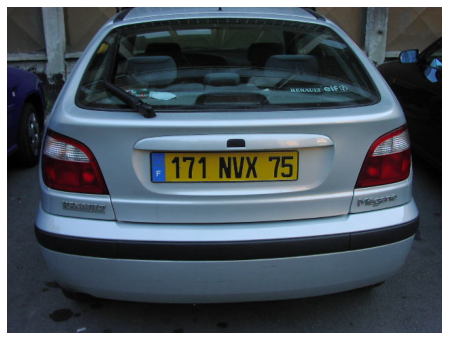

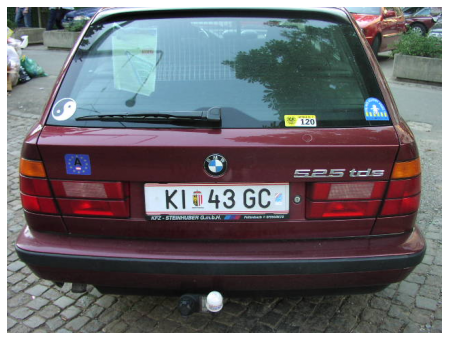

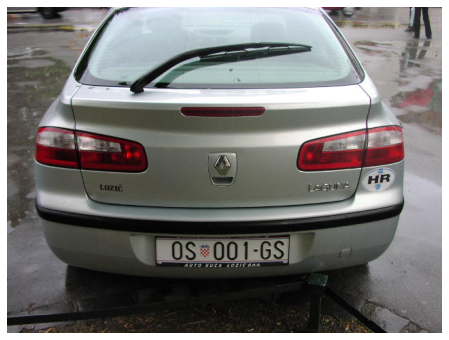

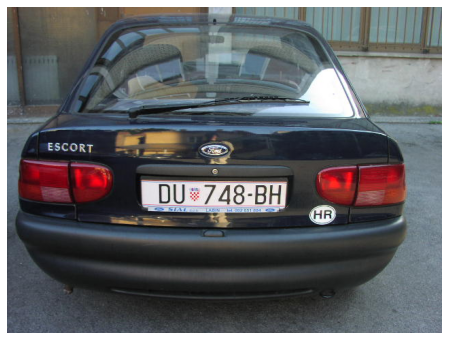

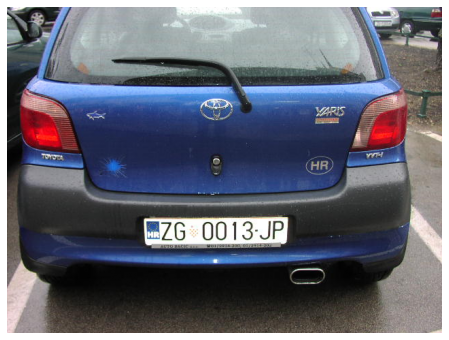

In [91]:
for filename in glob.glob('test/*.jpg'):
    test_image_path = filename
    vehicle, plate_image, coordinates = get_license_plate(test_image_path)
    
    plt.figure(figsize=(12,6))
    plt.axis(False)
    plt.imshow(vehicle)

## Model predictions and results on a test data

Our test images are saved in folder named 'images'. In this section we are trying to detect letters and numbers on license plate image using function 'get_license_plate' and several ways of image processing (convertScaleAbs, GaussianBlur, morphologyEx...). Once we have found the characters in the image we are using the 'char_model' model to determine license plate as a string. Strings of all images are saved into the list named 'results'. 

In [92]:
results = []
for filename in sorted(glob.glob('images/*.jpg')):
    
    test_image_path = filename
    vehicle, plate_image, coordinates = get_license_plate(test_image_path)

    if (len(plate_image)): 
        image = cv2.convertScaleAbs(plate_image[0], alpha=(255.0)) 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        blur = cv2.GaussianBlur(gray,(7,7) ,0) 
        binary = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]  
        tmp = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        dilated = cv2.morphologyEx(binary, cv2.MORPH_DILATE, tmp)

    contours, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    tmp_img = image.copy()  
    crop_characters = []              
    char_width, char_height = 30, 60 

    for c in sort(contours):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        
        # Only select contour with defined ratio
        if 1 <= ratio <= 6: 
        
            # Select contour which has the height larger than 50% of the plate
            if h/image.shape[0] >= 0.5:
                cv2.rectangle(tmp_img, (x, y), (x + w, y + h), (255, 0, 0), 2) # Draw rectangle arroung digit number
                curr_num = dilated[y:y+h, x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(char_width, char_height))
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                crop_characters.append(curr_num)

    final_string = ''
    for i, character in enumerate(crop_characters):
        title = np.array2string(predict(character, char_model, labels))
        final_string+=title.strip("'[]")

    results.append(final_string)

print('Results:')
print()
print(results)

Results:

['171NVX75', 'DU748BH', 'K143GC', 'ZG0013JP', '0S001GS', 'ZG1920T', 'ZG1720AJ', 'G209201', 'ZG87AR', 'ZG314U', 'S1582AM', 'G1846AC', 'G862NS', 'G106LU', 'ZG7949AD', 'ZG401CC', 'VU135F', '7G75PP3', 'ZG160DU', 'ZG790D0', 'ZG441AJ', '0G788P', 'Z6443TP', 'ZG679VF', 'ZG710KS', 'ZG2424B', 'ZG1001DJ', 'ZG5572AB', 'ZG248EB', 'ZG655SC', 'Z6210EH', 'ZG784FU', 'ZG966ZT', 'ZG41340', 'G120EL', 'ZG567EF', 'NG179AC', 'T317KJ', 'FFU1004', 'KA365CP', 'ZG789P1', 'DU900CF', 'ZG988TU', 'G692NZ', 'ZD601J', '325J521', 'SK253CL', 'ZG82971', 'P373KUU', 'G877TF', 'ZG4513P1', 'BJ100EE', 'KC538AG', 'ZD539CH', 'ZG763VE', 'BV678PX', 'ZG8000Z', 'ZG4240AC', 'W21337S', 'BV595KX', 'KA127C0', 'VT809T', 'KZ386L', 'PU2531B', 'H6AS18G2', 'ZG4459L', 'ZG4497P', 'ZG348CP', 'DU986BN', 'ZG416PZ', 'KA570CD', 'ZG7761N', 'Z62808AA', 'ZG1041P', 'ZG4847S', 'ZG754VV', 'BZG5023B', '78512C', 'ZG48KT', 'ZG006A6', 'ZG4932S', 'ZG977TT', 'AASH938', 'PZ898A0', 'ZG518JS', 'ZG8557AA', 'ZG9039L', 'TOLXC803', 'ZG594TS', 'ZG3710AL', '

## Calculating the accuracy of the model

The 'labels.txt' file contains the actual registrations of all cars from the data set required to evaluate the model. We compare predicted and actual values of license plates and calculate accuracy of our model as number of exactly predicted examples devided by total number of exmples in set. 

In [93]:
def compare(prediction,true):
    identical = True
    chars = ["1", "I", "0", "O", "S", "Š", "Z", "Ž"]
    if len(prediction) != len(true):
        return False
    for i in range(len(true)):
        if prediction[i] != true[i]:
            if prediction[i] not in chars:
                identical = False
    return identical

labels = []
with open('labels.txt') as f:
    for line in f:
        line = line.strip()
        labels.append(line)

cnt = 0
false_predictions = []

for i in range(len(labels)):
    if compare(results[i], labels[i]) is True:
        cnt = cnt + 1
    else:
        false_predictions.append(i)

acc = cnt/len(labels)
print(f'Model accuracy = {acc*100 :.3f} %')

Model accuracy = 75.728 %


## Calculating the Levenshtein distance

To further evaluate the model, we will use the Levenshtein distance to see what the deviations of the predictions of the actual values are. 

In [94]:
print("%-15s %-15s %-15s" %("Prediction", "True value", "Levenshtein distance"))
print()
for idx in false_predictions:
    print("%-15s %-15s %-15s" %(results[idx], labels[idx], str(lev(results[idx],labels[idx]))))

Prediction      True value      Levenshtein distance

G209201         ZG2092O         3              
ZG87AR          ZG5687AR        2              
G1846AC         ZG1846AC        1              
G862NS          ZG862NS         1              
G106LU          ZG106LU         1              
7G75PP3         ZG759RR         4              
Z6443TP         ZG443TP         1              
Z6210EH         ZG210EH         1              
G120EL          ZG120EL         1              
T317KJ          ST317KJ         1              
G692NZ          ZG692MZ         2              
P373KUU         RI373KI         4              
G877TF          ZG877TF         1              
ZG4513P1        ZG4513R         2              
BV678PX         BW678RX         2              
BV595KX         BV593KX         1              
H6AS18G2        HGAS1802        2              
ZG348CP         ZG348CR         1              
DU986BN         DU986BM         1              
ZG7761N         ZG7761M         1 